In [129]:
import pandas as pd
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [130]:
# Define folder paths
csv_folder = os.path.join(os.getcwd(), "csv_outputs")
json_folder = os.path.join(os.getcwd(), "json_outputs")

# Create folders if they don't exist
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(json_folder, exist_ok=True)

In [131]:
csv_folder = os.path.join(os.getcwd(), "csv_outputs")
json_folder = os.path.join(os.getcwd(), "json_outputs")

In [132]:
payment_lines_df = pd.read_excel('Data/Payment Lines.xlsx')
print("Columns:", payment_lines_df.columns.tolist(), "\n\n")
print("Sample data:\n", payment_lines_df.head())

Columns: ['CUSTOMER_NUMBER', 'FIN_PERIOD', 'DEPOSIT_DATE', 'DEPOSIT_REF', 'BANK_AMT', 'DISCOUNT', 'TOT_PAYMENT'] 


Sample data:
   CUSTOMER_NUMBER  FIN_PERIOD DEPOSIT_DATE DEPOSIT_REF  BANK_AMT  DISCOUNT  \
0          599000      201904   2019-06-27    DB04-153  -2046.30         0   
1          599000      201904   2019-06-28    DB04-180  -4132.50         0   
2          599000      201905   2019-07-04    DB05-036   -287.00         0   
3          599000      201905   2019-07-09    DB05-061  -2685.27         0   
4          599000      201905   2019-07-16    DB05-118   -229.14         0   

   TOT_PAYMENT  
0        -2046  
1        -4132  
2         -287  
3        -2685  
4         -229  


In [133]:
print("Null values:\n", payment_lines_df.isnull().sum())

Null values:
 CUSTOMER_NUMBER    0
FIN_PERIOD         0
DEPOSIT_DATE       0
DEPOSIT_REF        0
BANK_AMT           0
DISCOUNT           0
TOT_PAYMENT        0
dtype: int64


In [134]:
# Remove rows with any null values
payment_lines_df = payment_lines_df.dropna()

In [135]:
print("Data shape:", payment_lines_df.shape)

Data shape: (2646, 7)


In [136]:
payment_lines_df

,CUSTOMER_NUMBER,FIN_PERIOD,DEPOSIT_DATE,DEPOSIT_REF,BANK_AMT,DISCOUNT,TOT_PAYMENT
0,599000,201904,2019-06-27,DB04-153,-2046.30,0,-2046
1,599000,201904,2019-06-28,DB04-180,-4132.50,0,-4132
2,599000,201905,2019-07-04,DB05-036,-287.00,0,-287
3,599000,201905,2019-07-09,DB05-061,-2685.27,0,-2685
4,599000,201905,2019-07-16,DB05-118,-229.14,0,-229
...,...,...,...,...,...,...,...
2641,ZNAE01,201909,2019-11-20,DD09-013,-4391.84,0,-4391
2642,ZNAO01,201904,2019-06-10,DD04-005,-600.00,0,-600
2643,ZNAO01,201908,2019-10-02,DD08-014,-1023.73,0,-1023
2644,ZNAO01,201909,2019-11-21,DD09-014,-500.00,0,-500


In [137]:
payment_lines_df['CUSTOMER_NUMBER'] = payment_lines_df['CUSTOMER_NUMBER'].astype(str).str.strip().str.upper()
valid_mask = payment_lines_df['CUSTOMER_NUMBER'].str.match(r'^[A-Z]{4}([0-9]{2}|[A-Z]{2}|[A-Z][0-9])$', na=False)

valid_df = payment_lines_df[valid_mask].copy()
invalid_df = payment_lines_df[~valid_mask].copy()

In [138]:
valid_df['DEPOSIT_DATE'] = pd.to_datetime(valid_df['DEPOSIT_DATE'], errors='coerce')
valid_df = valid_df.dropna(subset=['DEPOSIT_DATE'])

In [139]:
valid_df

,CUSTOMER_NUMBER,FIN_PERIOD,DEPOSIT_DATE,DEPOSIT_REF,BANK_AMT,DISCOUNT,TOT_PAYMENT
49,AAMI01,201909,2019-11-06,DB09-026,-906.24,0,-906
50,ABHG01,201906,2019-08-30,DB06-176,-860.93,-45,-860
51,ABHN01,201908,2019-10-29,DB08-195,-655.16,-34,-655
52,ABHN02,201909,2019-11-29,DB09-181,-536.09,-24,-536
53,ABRC01,201905,2019-07-05,DB05-041,-929.44,-40,-928
...,...,...,...,...,...,...,...
2641,ZNAE01,201909,2019-11-20,DD09-013,-4391.84,0,-4391
2642,ZNAO01,201904,2019-06-10,DD04-005,-600.00,0,-600
2643,ZNAO01,201908,2019-10-02,DD08-014,-1023.73,0,-1023
2644,ZNAO01,201909,2019-11-21,DD09-014,-500.00,0,-500


In [140]:
valid_df.to_csv(os.path.join(csv_folder, "payment_lines_clean.csv"), index=False)
valid_df.to_json(os.path.join(json_folder, "payment_lines_clean.json"), orient="records", lines=True)

In [141]:
# Ensure FIN_PERIOD is 6 digits: YYYYMM
valid_df['FIN_PERIOD'] = valid_df['FIN_PERIOD'].astype(str).str.strip()
valid_fin_mask = valid_df['FIN_PERIOD'].str.match(r'^\d{6}$')
valid_df = valid_df[valid_fin_mask]

In [142]:
import calendar
from datetime import datetime, timedelta

def get_financial_month_range(fin_period):
    year = int(fin_period[:4])
    month = int(fin_period[4:])

    # Last Saturday of previous month
    prev_month = month - 1 if month > 1 else 12
    prev_year = year if month > 1 else year - 1
    last_day_prev_month = calendar.monthrange(prev_year, prev_month)[1]
    last_saturday = max(
        datetime(prev_year, prev_month, d)
        for d in range(last_day_prev_month - 6, last_day_prev_month + 1)
        if datetime(prev_year, prev_month, d).weekday() == 5
    )

    # Last Friday of current month
    last_day_curr_month = calendar.monthrange(year, month)[1]
    last_friday = max(
        datetime(year, month, d)
        for d in range(last_day_curr_month - 6, last_day_curr_month + 1)
        if datetime(year, month, d).weekday() == 4
    )

    return last_saturday, last_friday

In [143]:
def is_date_in_fin_period(row):
    start, end = get_financial_month_range(row['FIN_PERIOD'])
    return start <= row['DEPOSIT_DATE'] <= end

valid_df['VALID_DATE_ALIGNMENT'] = valid_df.apply(is_date_in_fin_period, axis=1)
aligned_df = valid_df[valid_df['VALID_DATE_ALIGNMENT']].copy()
misaligned_df = valid_df[~valid_df['VALID_DATE_ALIGNMENT']].copy()

In [144]:
# Count transactions per period
period_summary = valid_df.groupby('FIN_PERIOD').size().reset_index(name='Transaction_Count')

# Optional: total payments per period
payment_summary = valid_df.groupby('FIN_PERIOD')['TOT_PAYMENT'].sum().reset_index()

payment_summary.to_csv(os.path.join(csv_folder, "dim_payment_summary.csv"), index=False)
payment_summary.to_json(os.path.join(json_folder, "dim_payment_summary.json"), orient="records", lines=True)

In [145]:
# Ensure numeric types
valid_df['BANK_AMT'] = pd.to_numeric(valid_df['BANK_AMT'], errors='coerce')
valid_df['DISCOUNT'] = pd.to_numeric(valid_df['DISCOUNT'], errors='coerce')
valid_df['TOT_PAYMENT'] = pd.to_numeric(valid_df['TOT_PAYMENT'], errors='coerce')

# Drop rows with missing or zero payment
valid_df = valid_df[valid_df['TOT_PAYMENT'] != 0]

valid_df

,CUSTOMER_NUMBER,FIN_PERIOD,DEPOSIT_DATE,DEPOSIT_REF,BANK_AMT,DISCOUNT,TOT_PAYMENT,VALID_DATE_ALIGNMENT
49,AAMI01,201909,2019-11-06,DB09-026,-906.24,0,-906,False
50,ABHG01,201906,2019-08-30,DB06-176,-860.93,-45,-860,False
51,ABHN01,201908,2019-10-29,DB08-195,-655.16,-34,-655,False
52,ABHN02,201909,2019-11-29,DB09-181,-536.09,-24,-536,False
53,ABRC01,201905,2019-07-05,DB05-041,-929.44,-40,-928,False
...,...,...,...,...,...,...,...,...
2641,ZNAE01,201909,2019-11-20,DD09-013,-4391.84,0,-4391,False
2642,ZNAO01,201904,2019-06-10,DD04-005,-600.00,0,-600,False
2643,ZNAO01,201908,2019-10-02,DD08-014,-1023.73,0,-1023,False
2644,ZNAO01,201909,2019-11-21,DD09-014,-500.00,0,-500,False


## VISUALIZATION

### Payment Volume Over Time

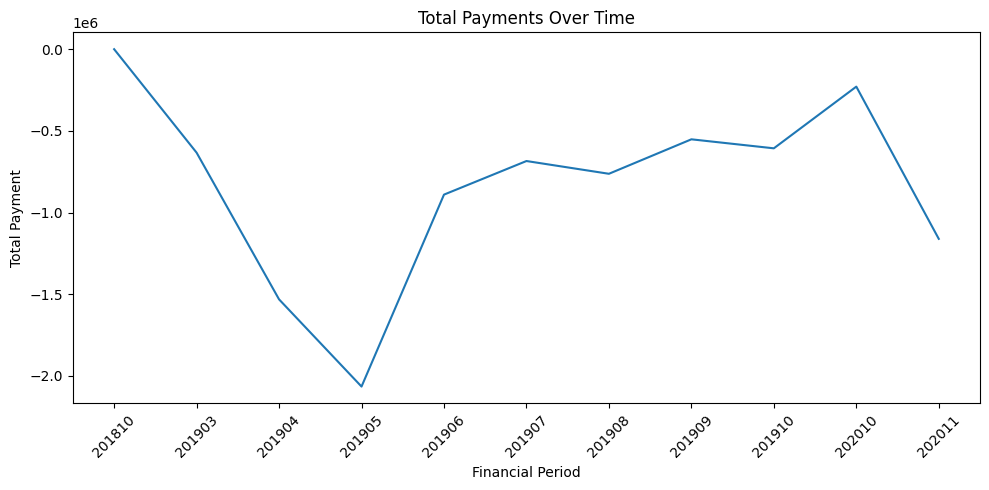

In [146]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=payment_summary, x='FIN_PERIOD', y='TOT_PAYMENT')
plt.title('Total Payments Over Time')
plt.xlabel('Financial Period')
plt.ylabel('Total Payment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top Customers by Payment Volume

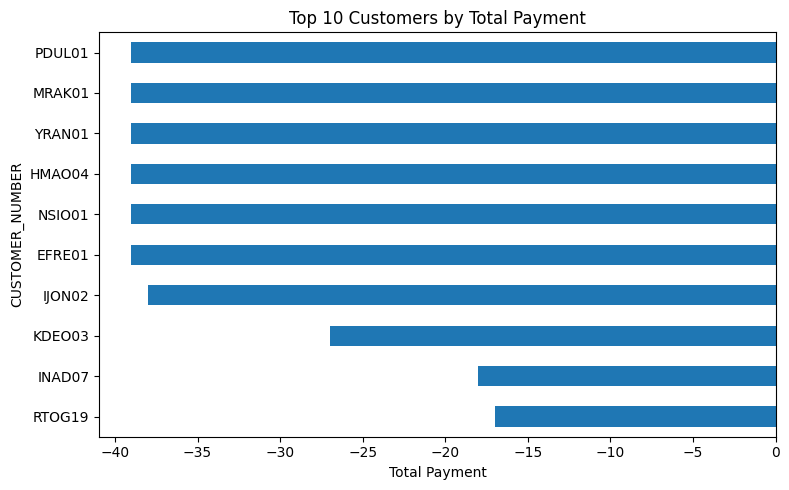

In [147]:
top_customers = valid_df.groupby('CUSTOMER_NUMBER')['TOT_PAYMENT'].sum().sort_values(ascending=False).head(10)

top_customers.plot(kind='barh', figsize=(8, 5), title='Top 10 Customers by Total Payment')
plt.xlabel('Total Payment')
plt.tight_layout()
plt.show()

### Payment Frequency by Customer

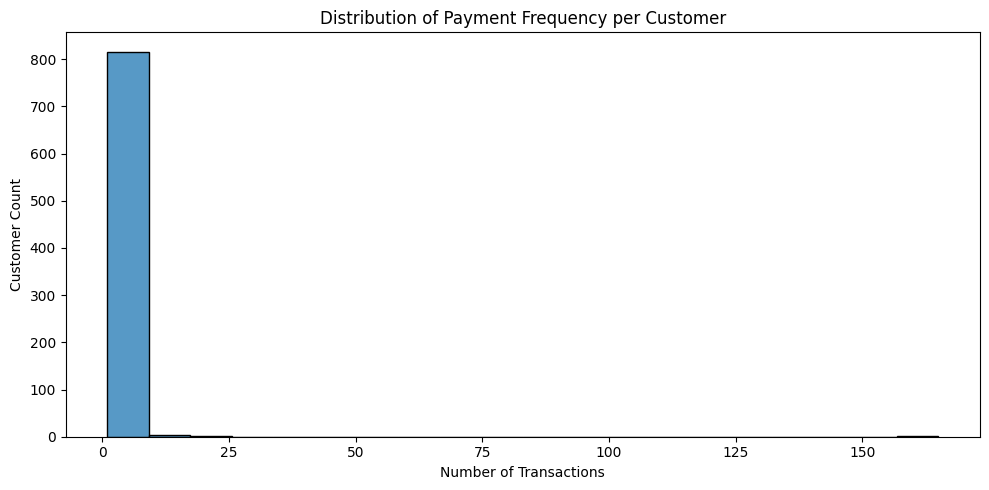

In [148]:
payment_freq = valid_df.groupby('CUSTOMER_NUMBER').size().reset_index(name='Num_Transactions')

plt.figure(figsize=(10, 5))
sns.histplot(payment_freq['Num_Transactions'], bins=20)
plt.title('Distribution of Payment Frequency per Customer')
plt.xlabel('Number of Transactions')
plt.ylabel('Customer Count')
plt.tight_layout()
plt.show()